In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py

In [2]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('.gitignore')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  49


['permutations/total_ring_mass=5e-09_radial_width=0.0005_shear_viscosity=2.499999999999997e-12_sim_id=42_timesteps_per_output=3300_',
 'permutations/total_ring_mass=5e-09_radial_width=0.0005_shear_viscosity=1.1603972084031956e-11_sim_id=46_timesteps_per_output=710_',
 'permutations/total_ring_mass=4.999999999999994e-10_radial_width=0.0005_shear_viscosity=1.7032301726449038e-11_sim_id=5_timesteps_per_output=48_',
 'permutations/total_ring_mass=1.0772173450159398e-09_radial_width=0.0005_shear_viscosity=1.7032301726449038e-11_sim_id=19_timesteps_per_output=104_',
 'permutations/total_ring_mass=7.338996338110336e-10_radial_width=0.0005_shear_viscosity=1.1603972084031956e-11_sim_id=11_timesteps_per_output=104_']

In [3]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import pandas as pd

In [4]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('_timesteps_per_output=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/total_ring_mass=4.999999999999994...
1       1  permutations/total_ring_mass=4.999999999999994...
2       2  permutations/total_ring_mass=4.999999999999994...
3       3  permutations/total_ring_mass=4.999999999999994...
4       4  permutations/total_ring_mass=4.999999999999994...

In [5]:
#set power laws for ringlet's dynamical timescale = time for e_prime to reach 0.6, which is assumed to vary as 
#(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
nominal_dynamical_timescale = 1.65e4
mass_power_law = 1.0
viscosity_power_law = -1.0
width_power_law = -0.33

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:56: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:58: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)


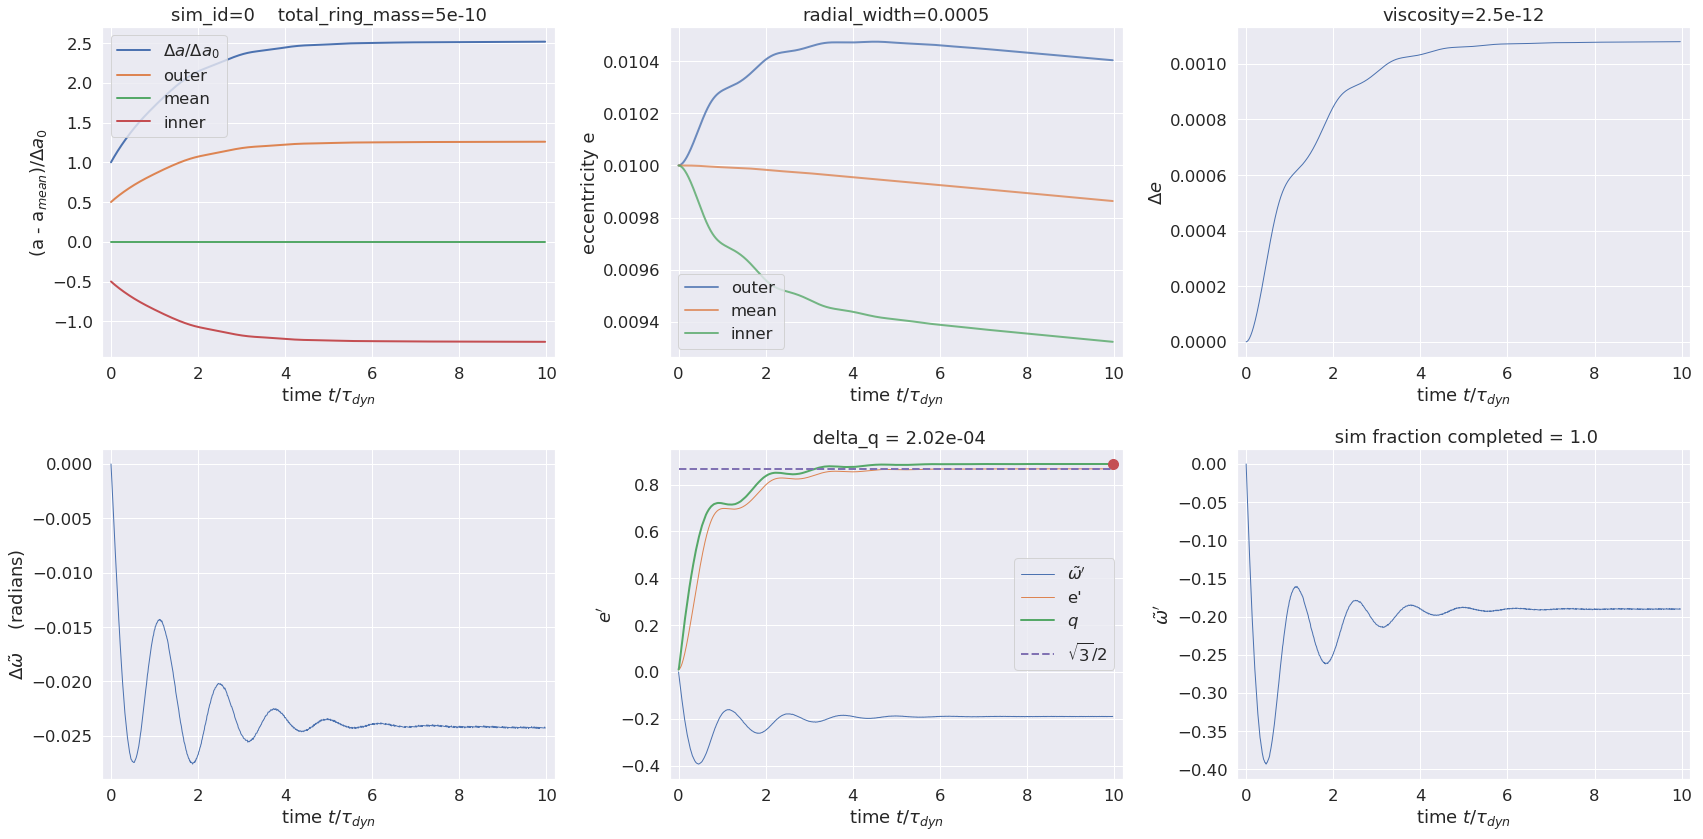

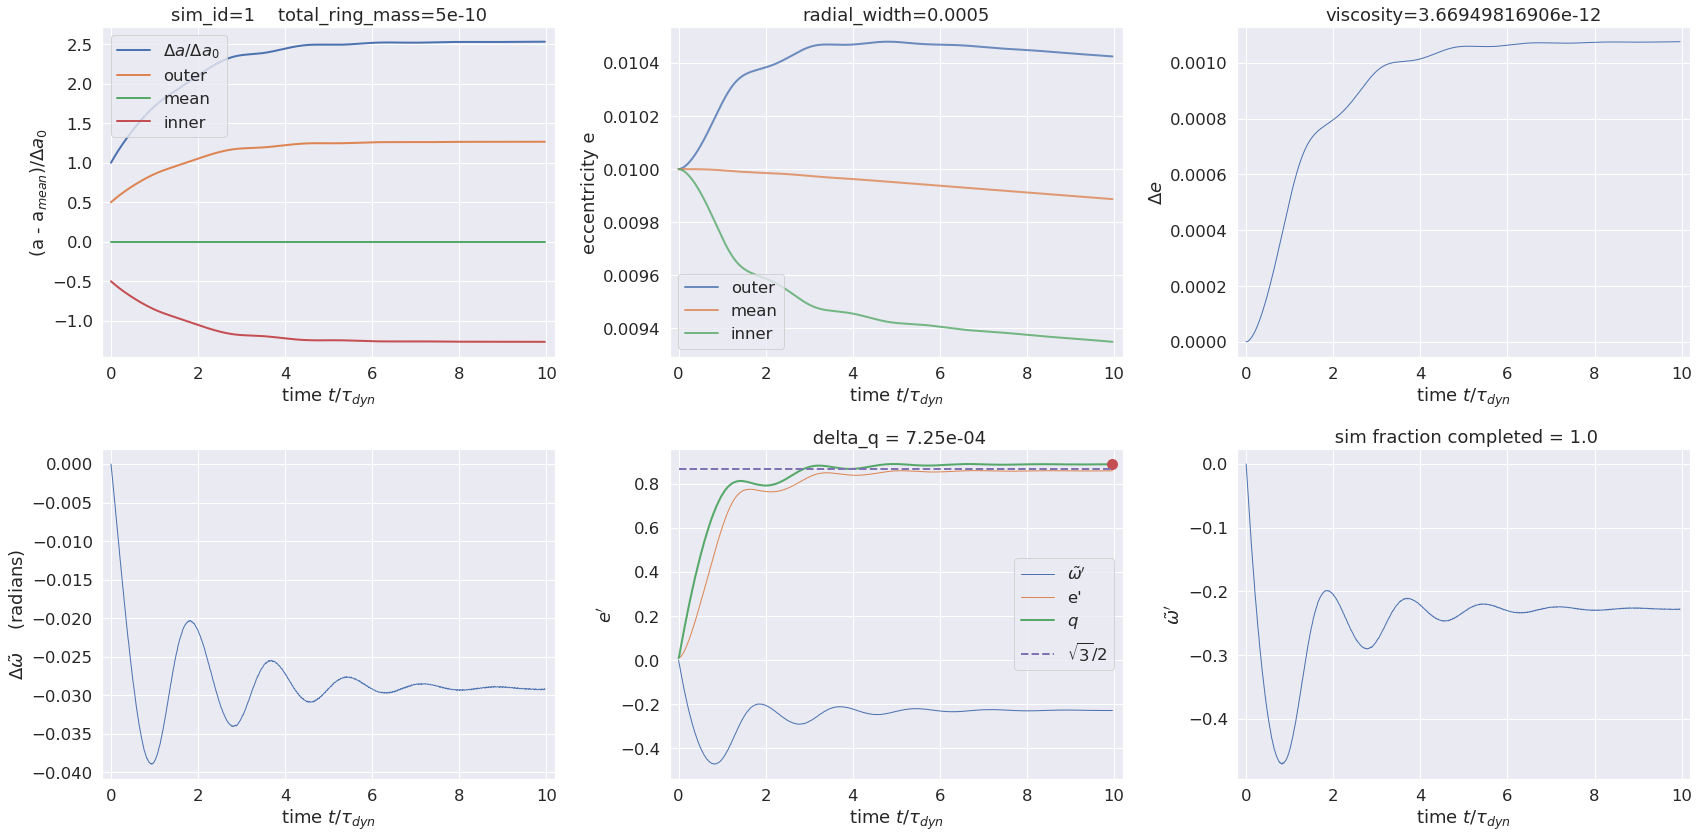

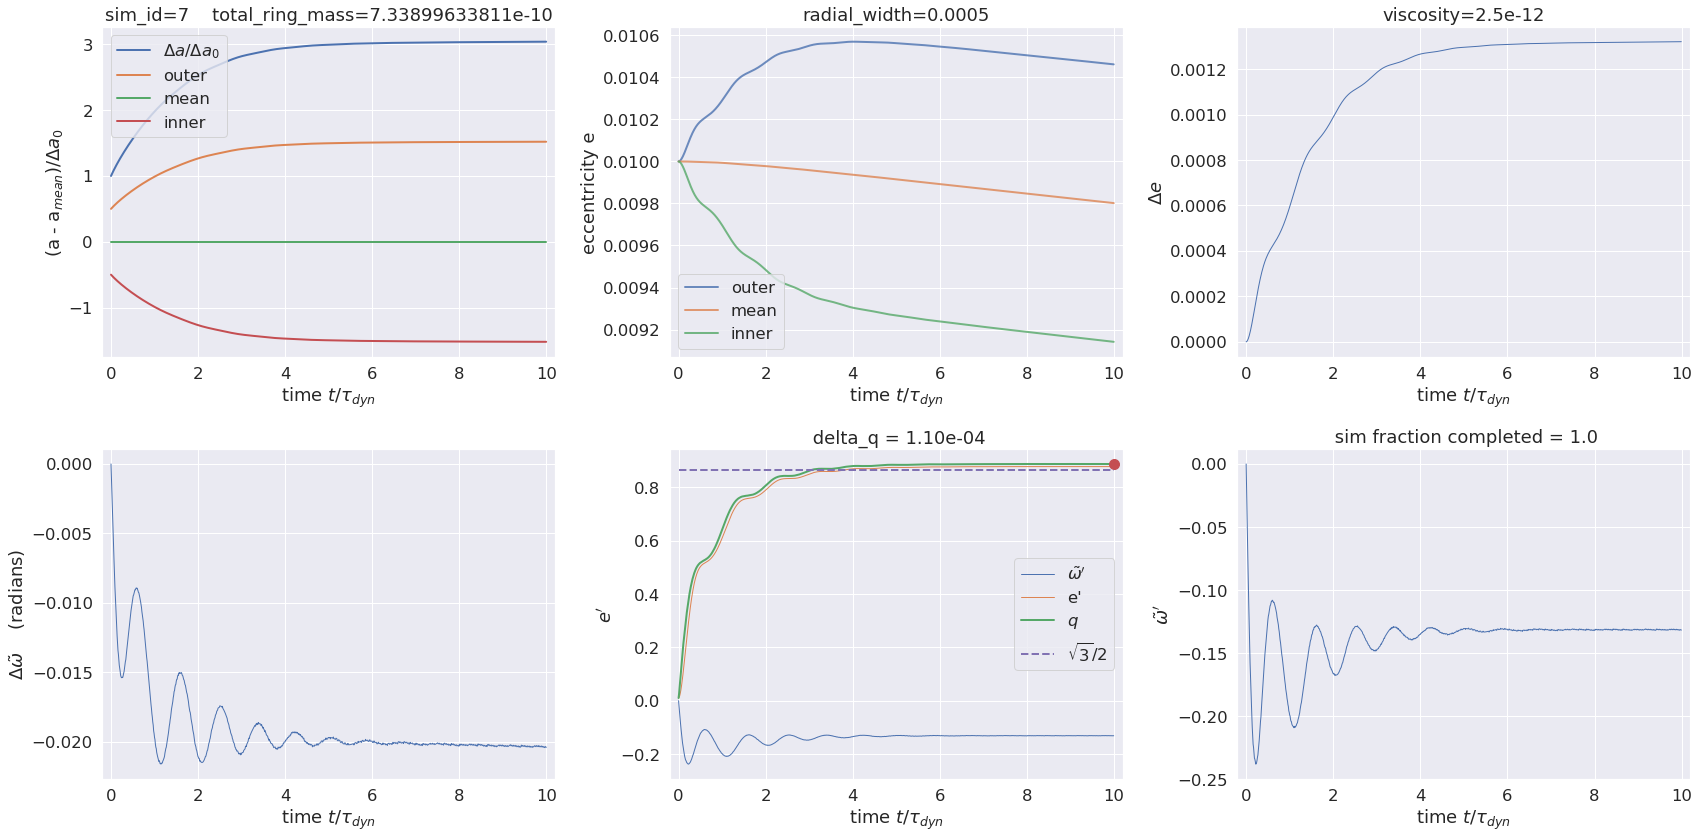

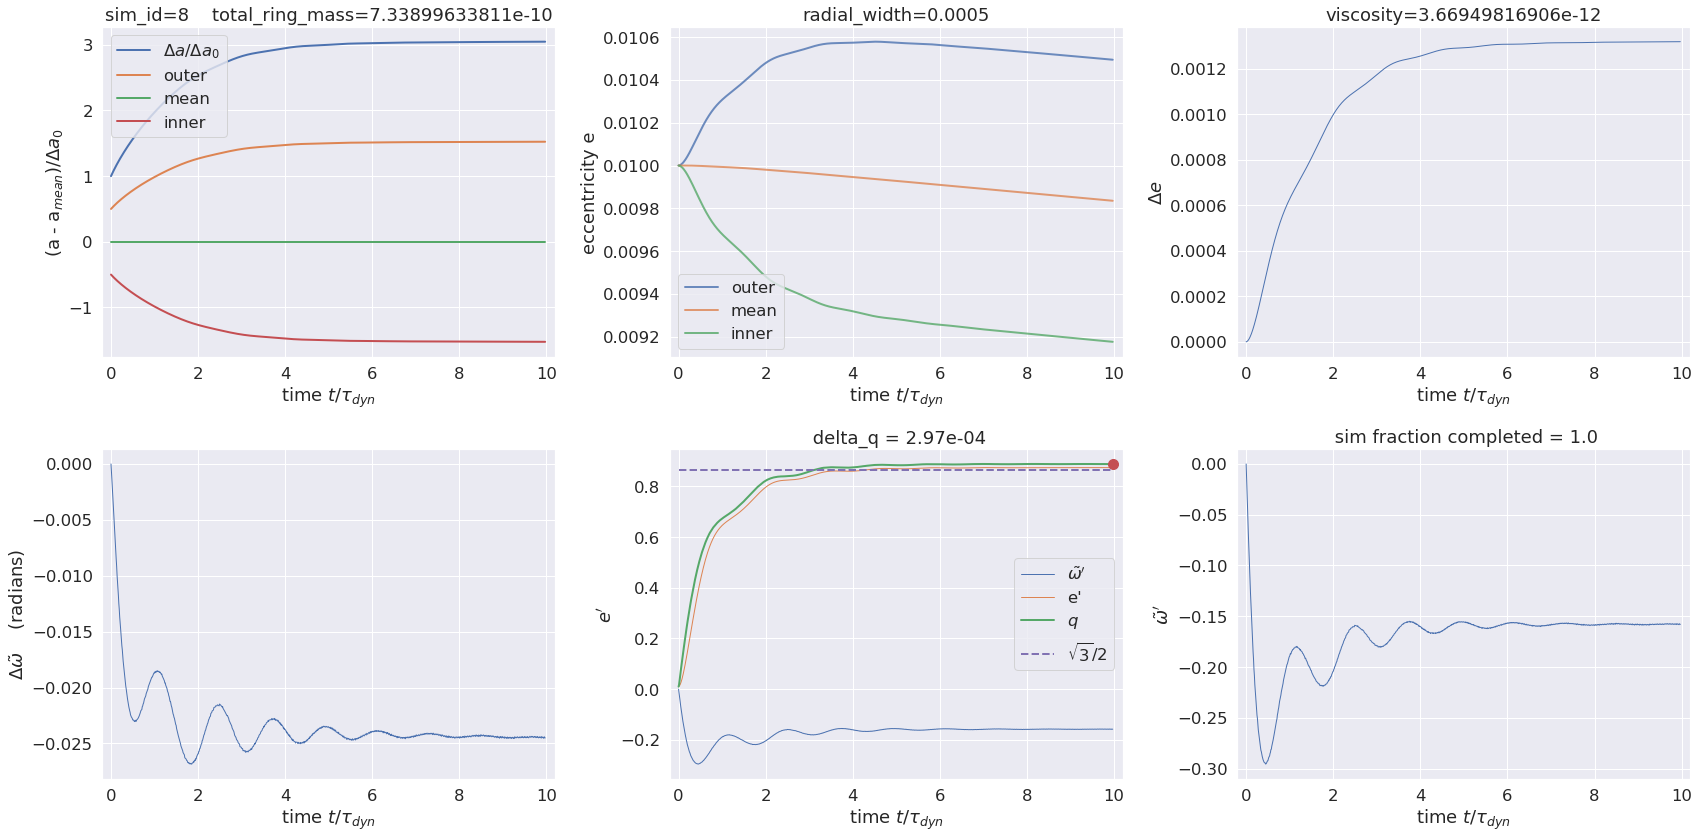

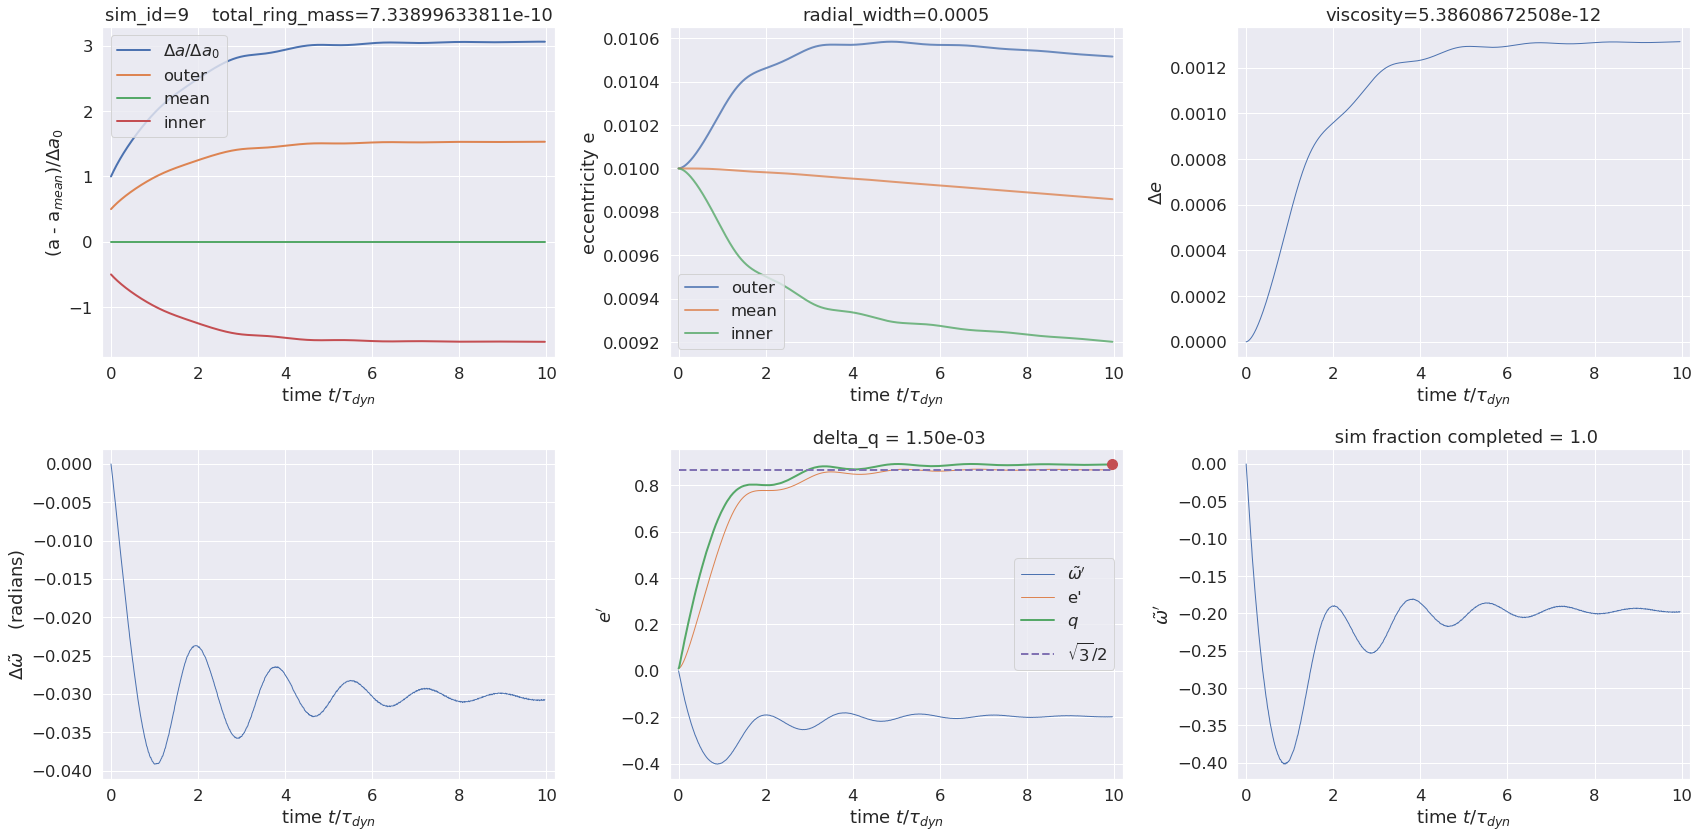

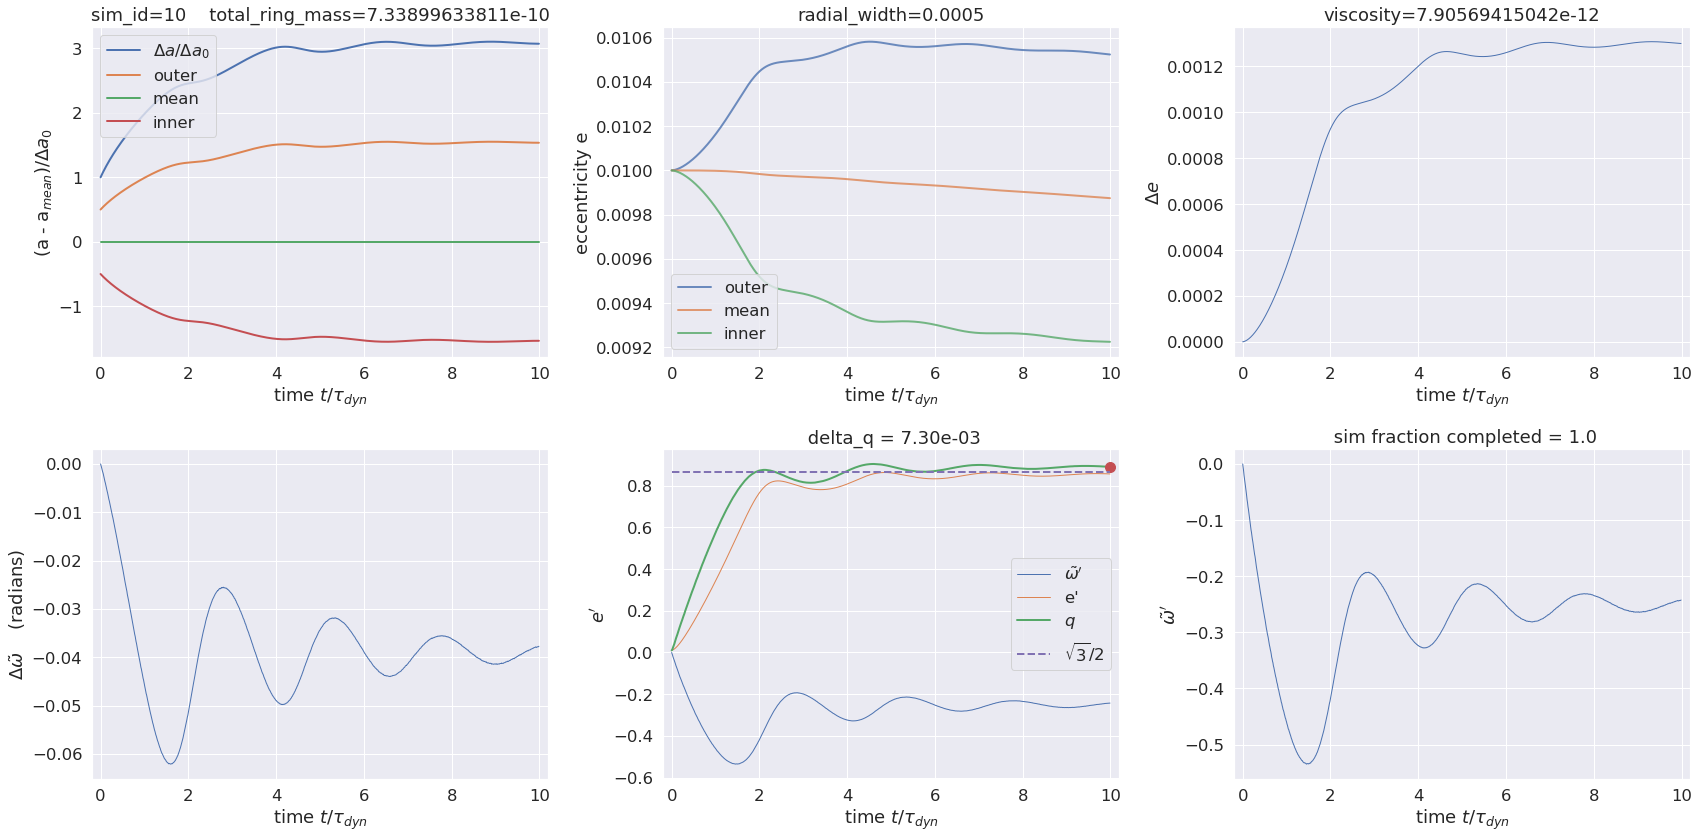

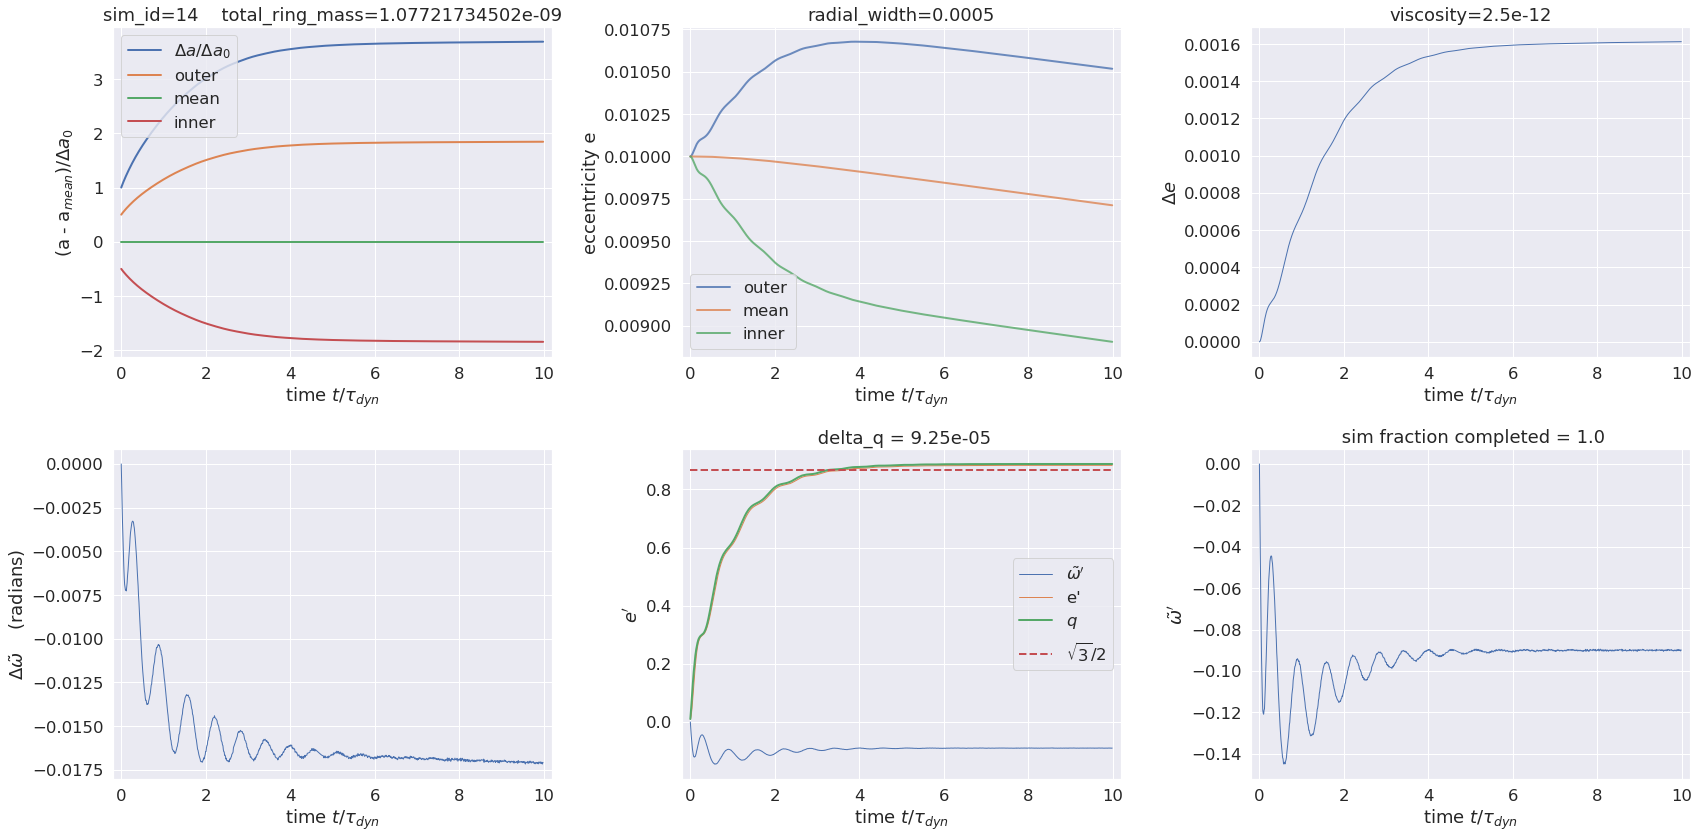

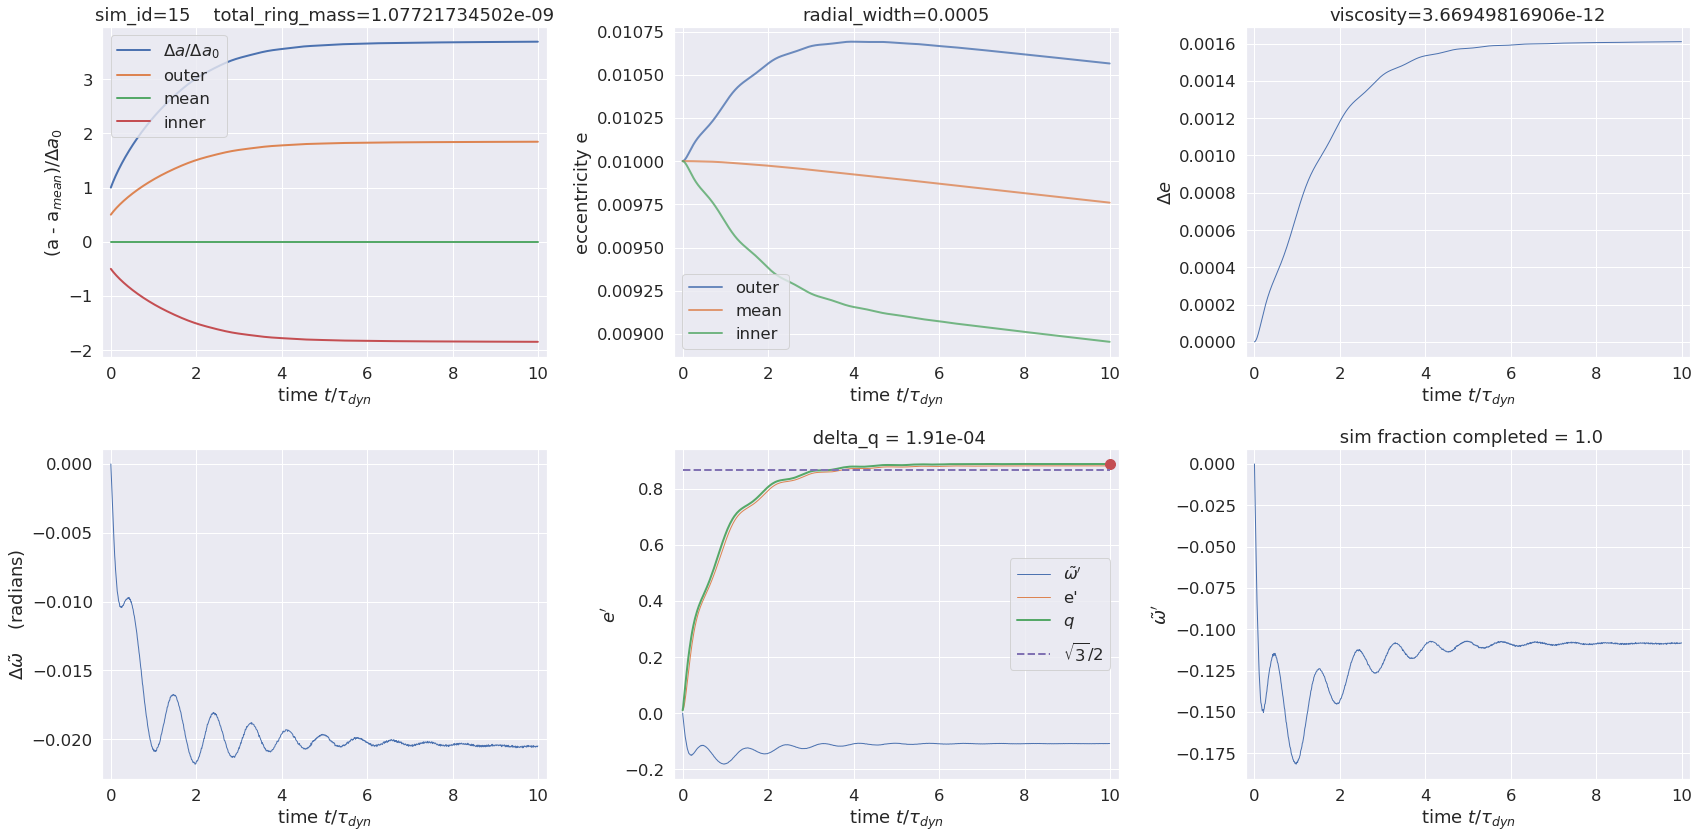

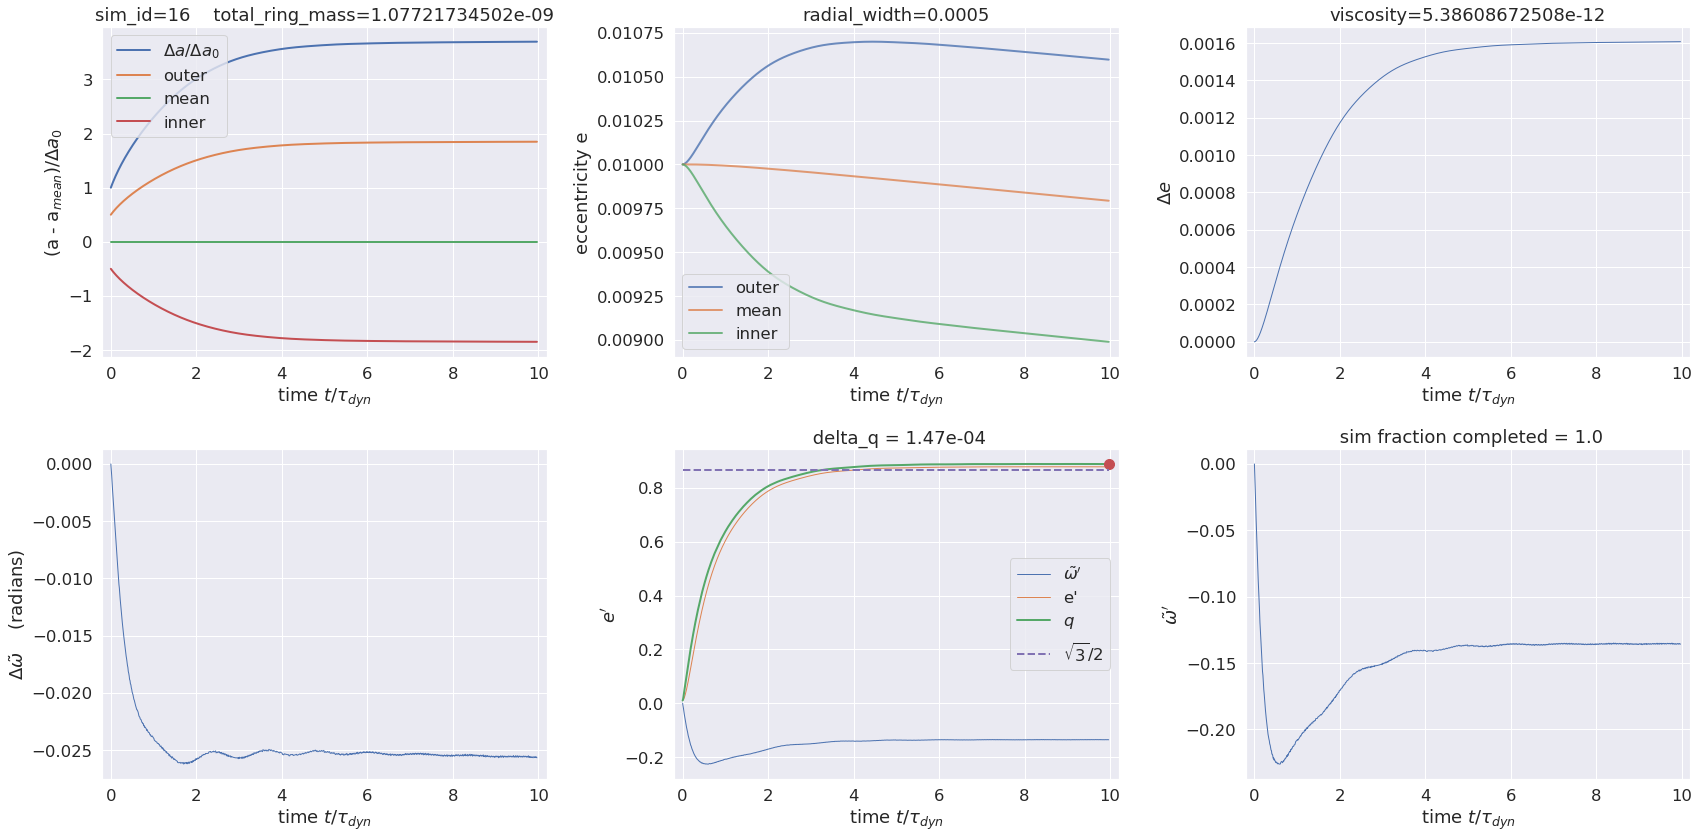

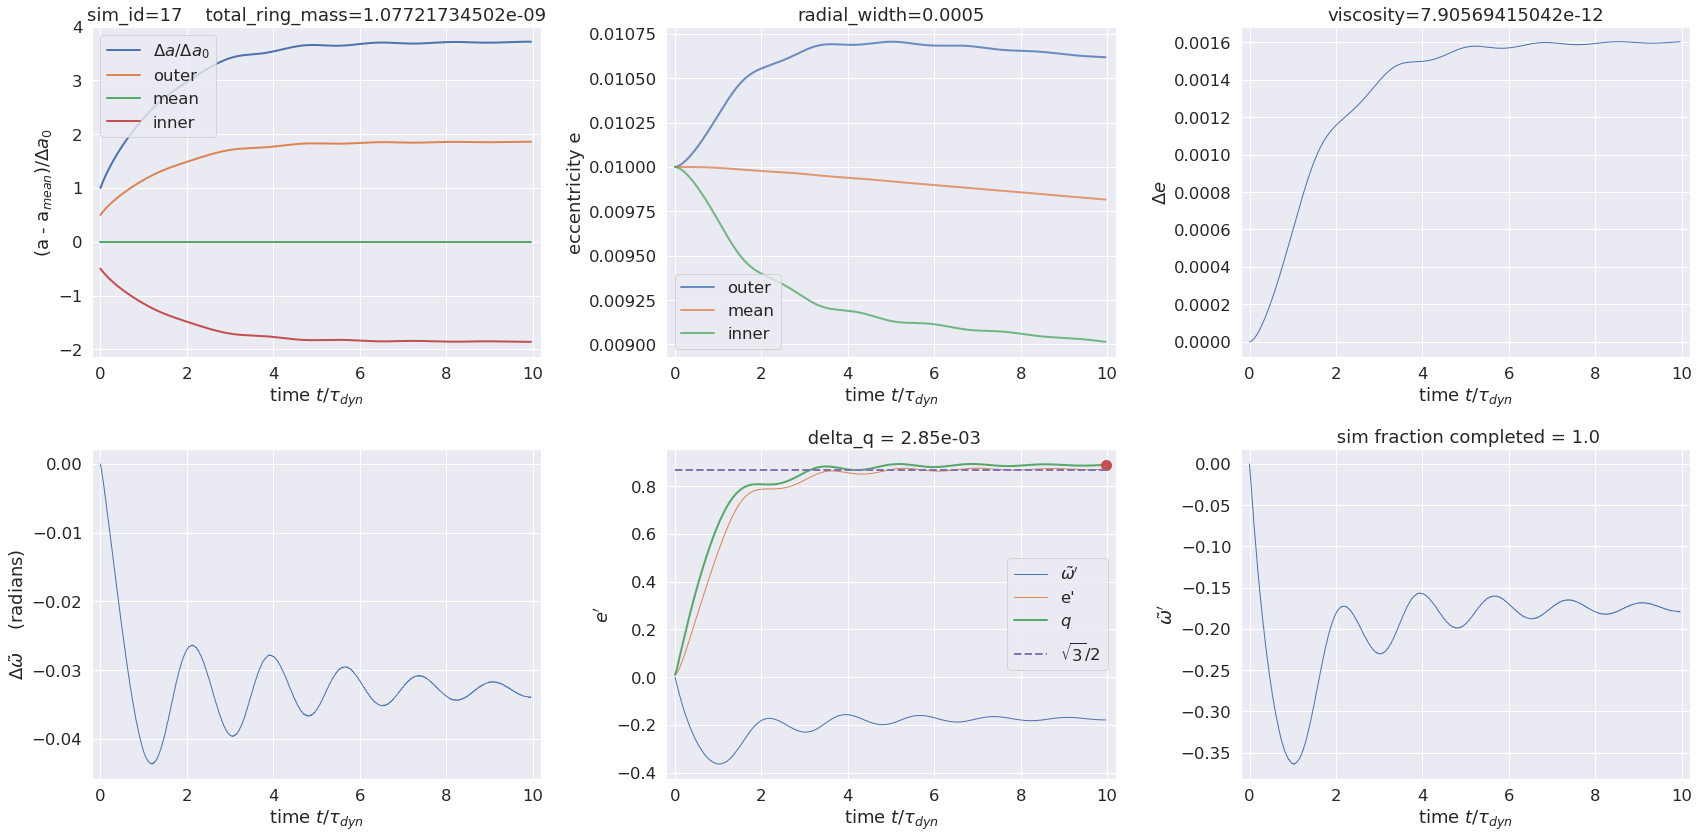

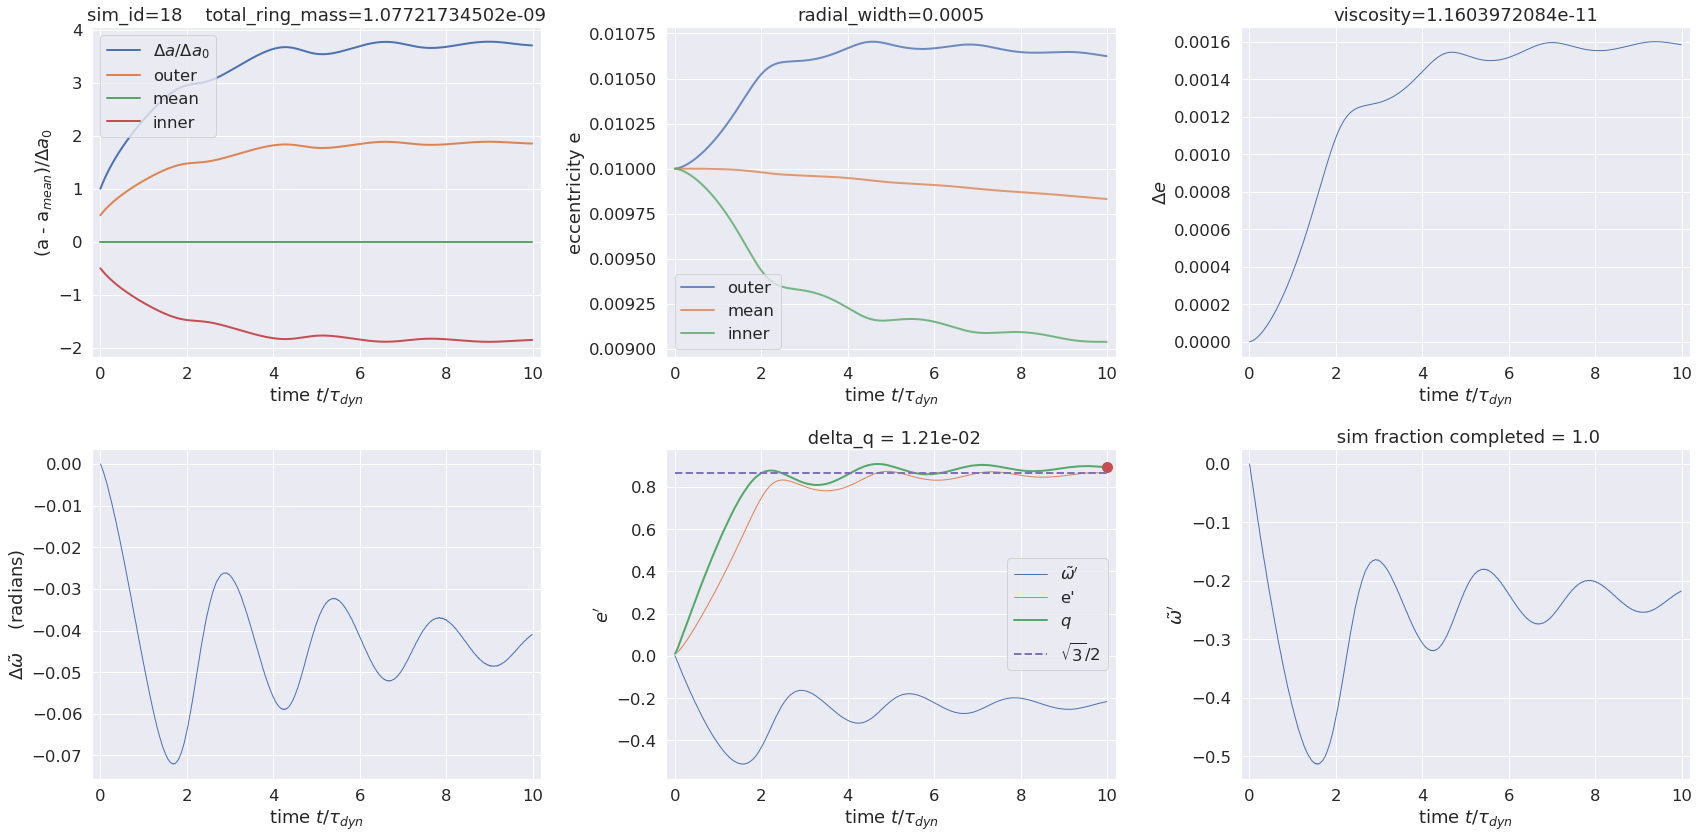

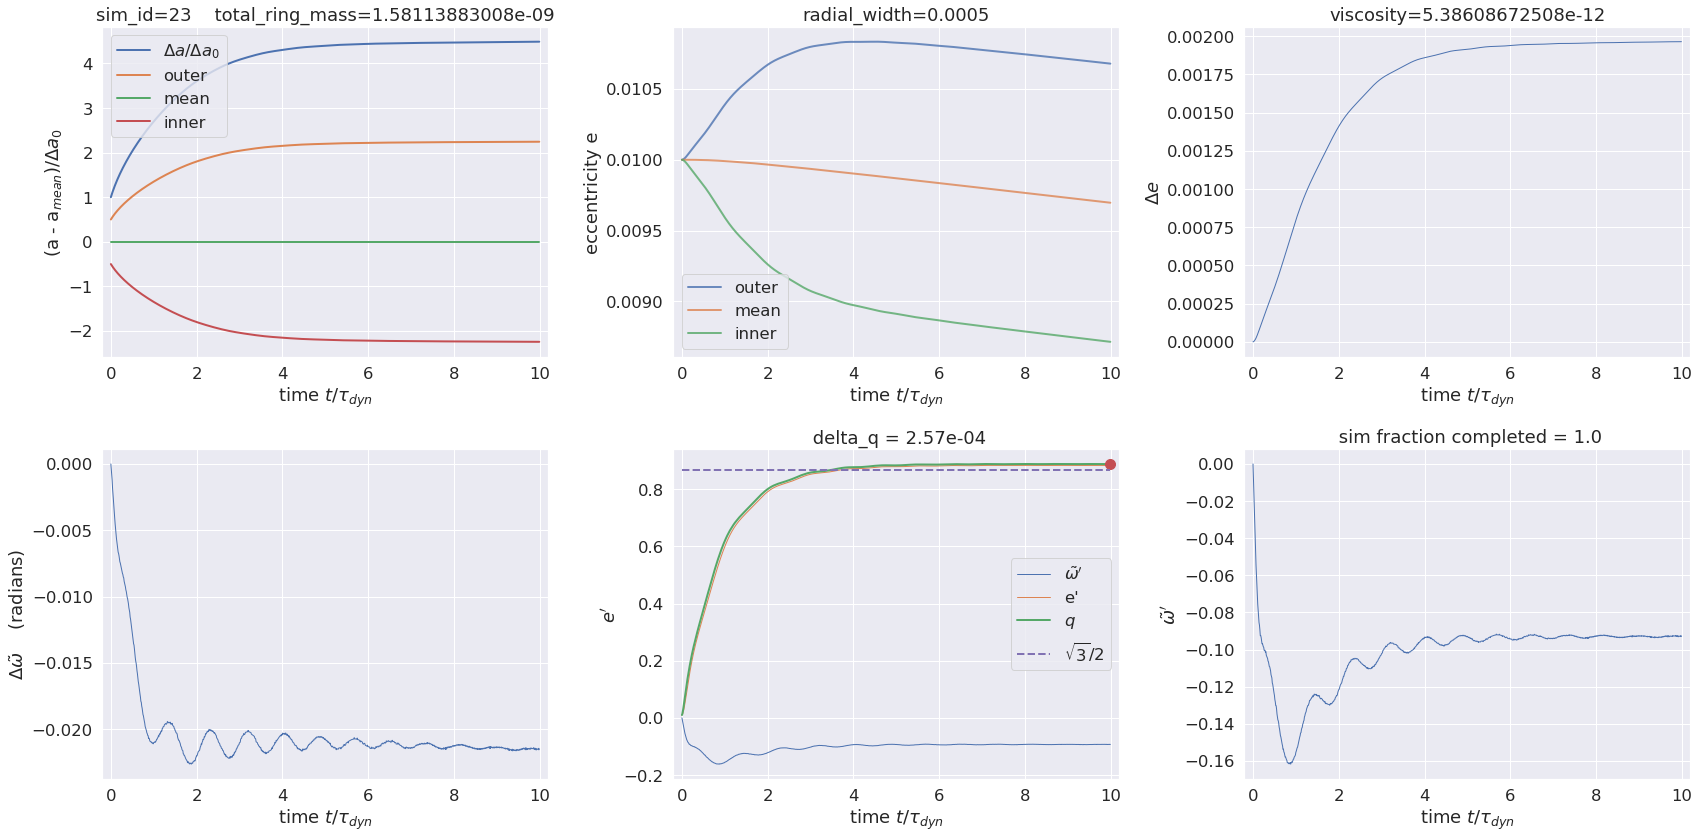

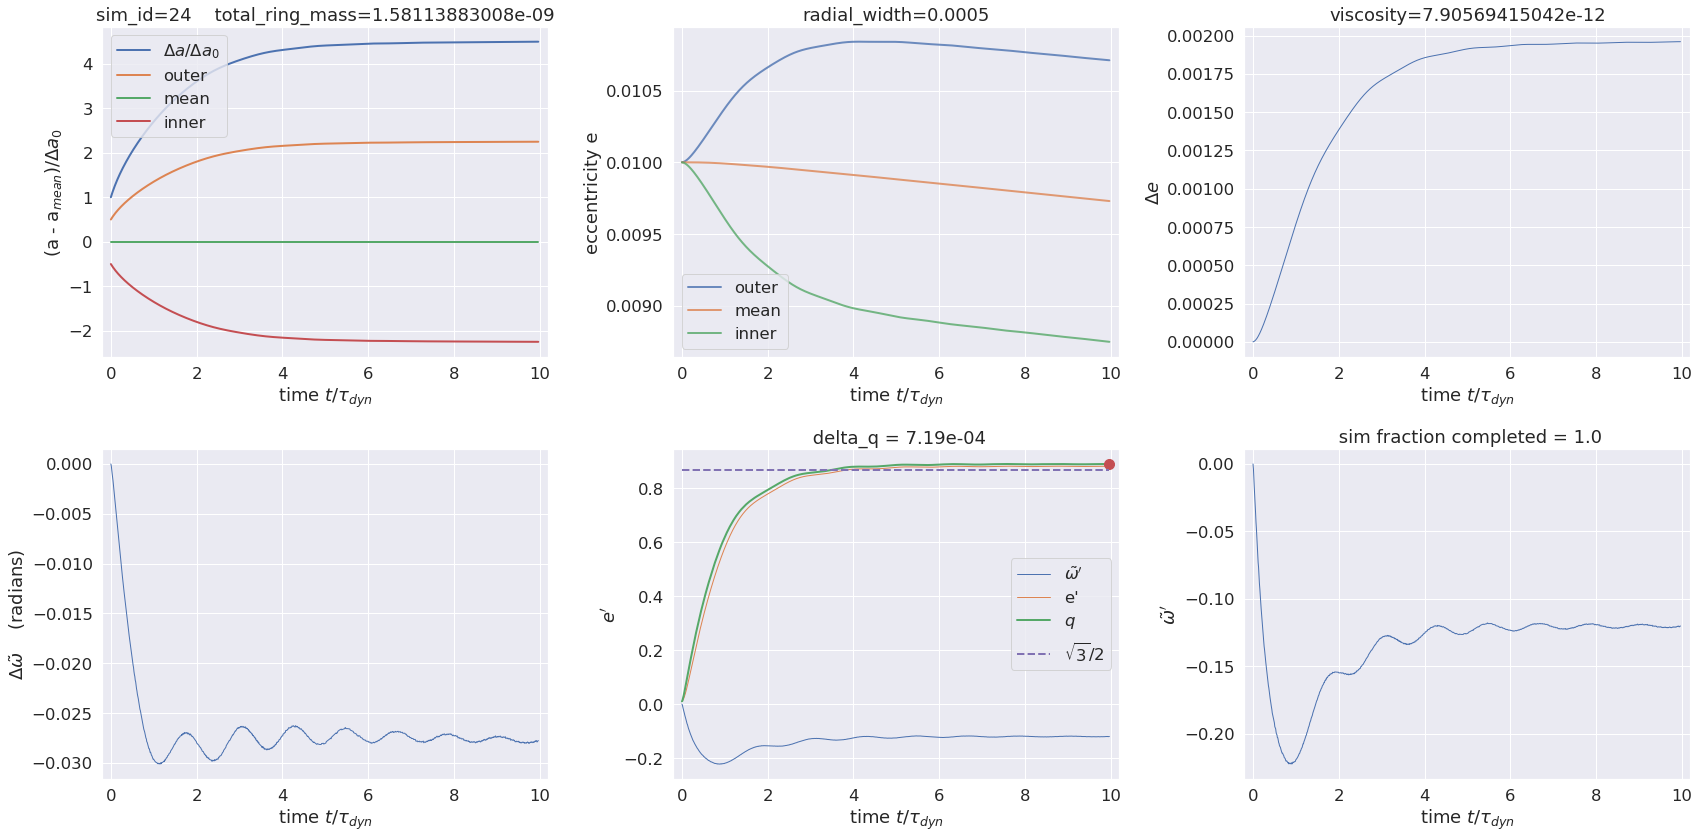

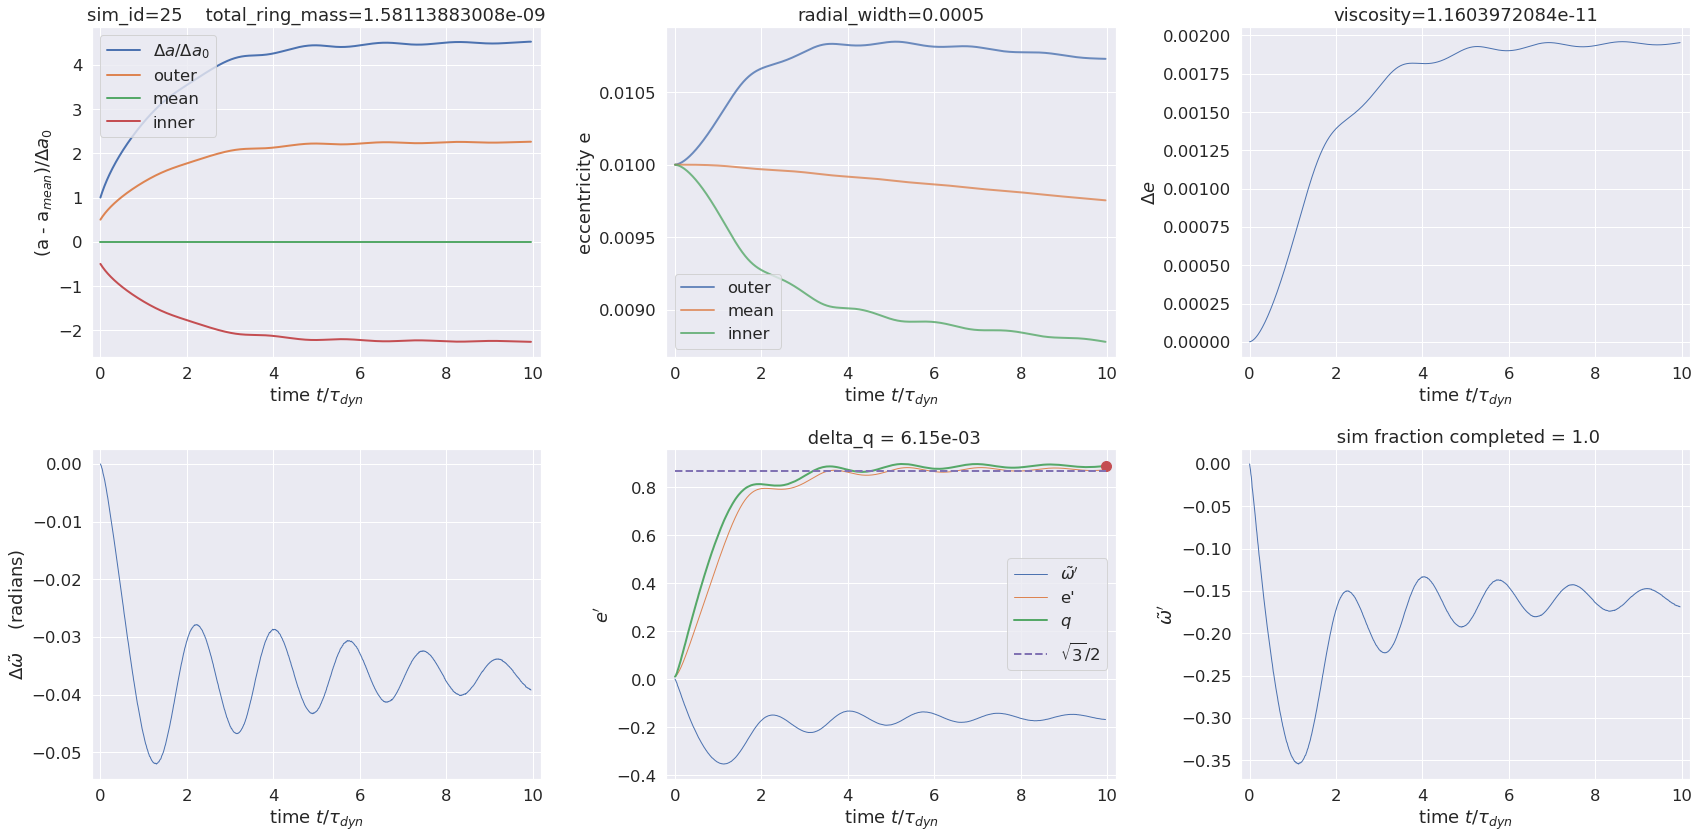

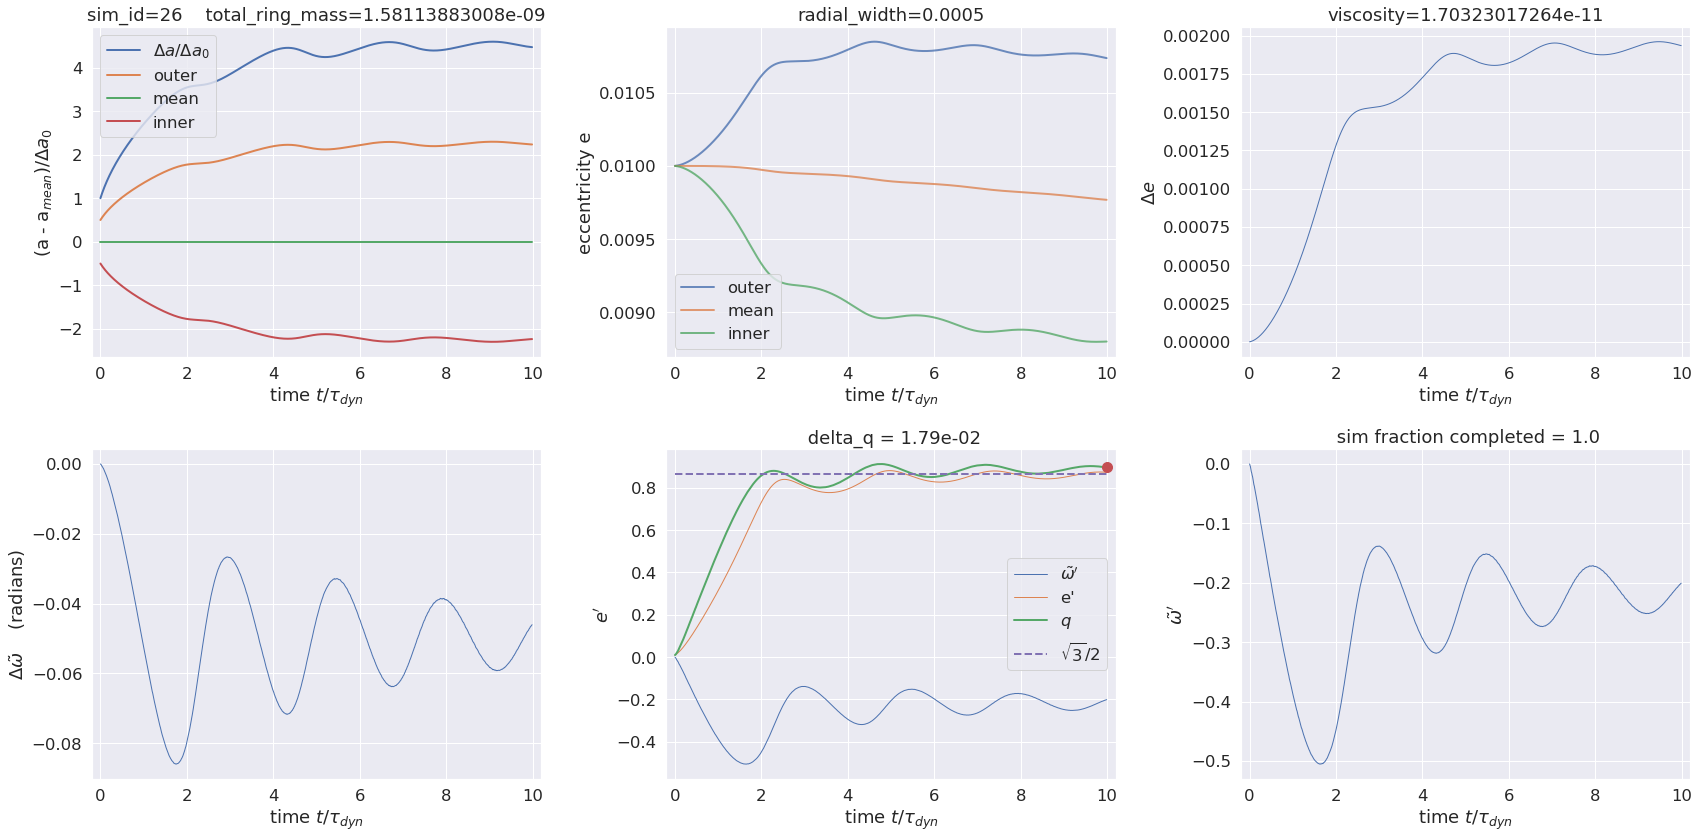

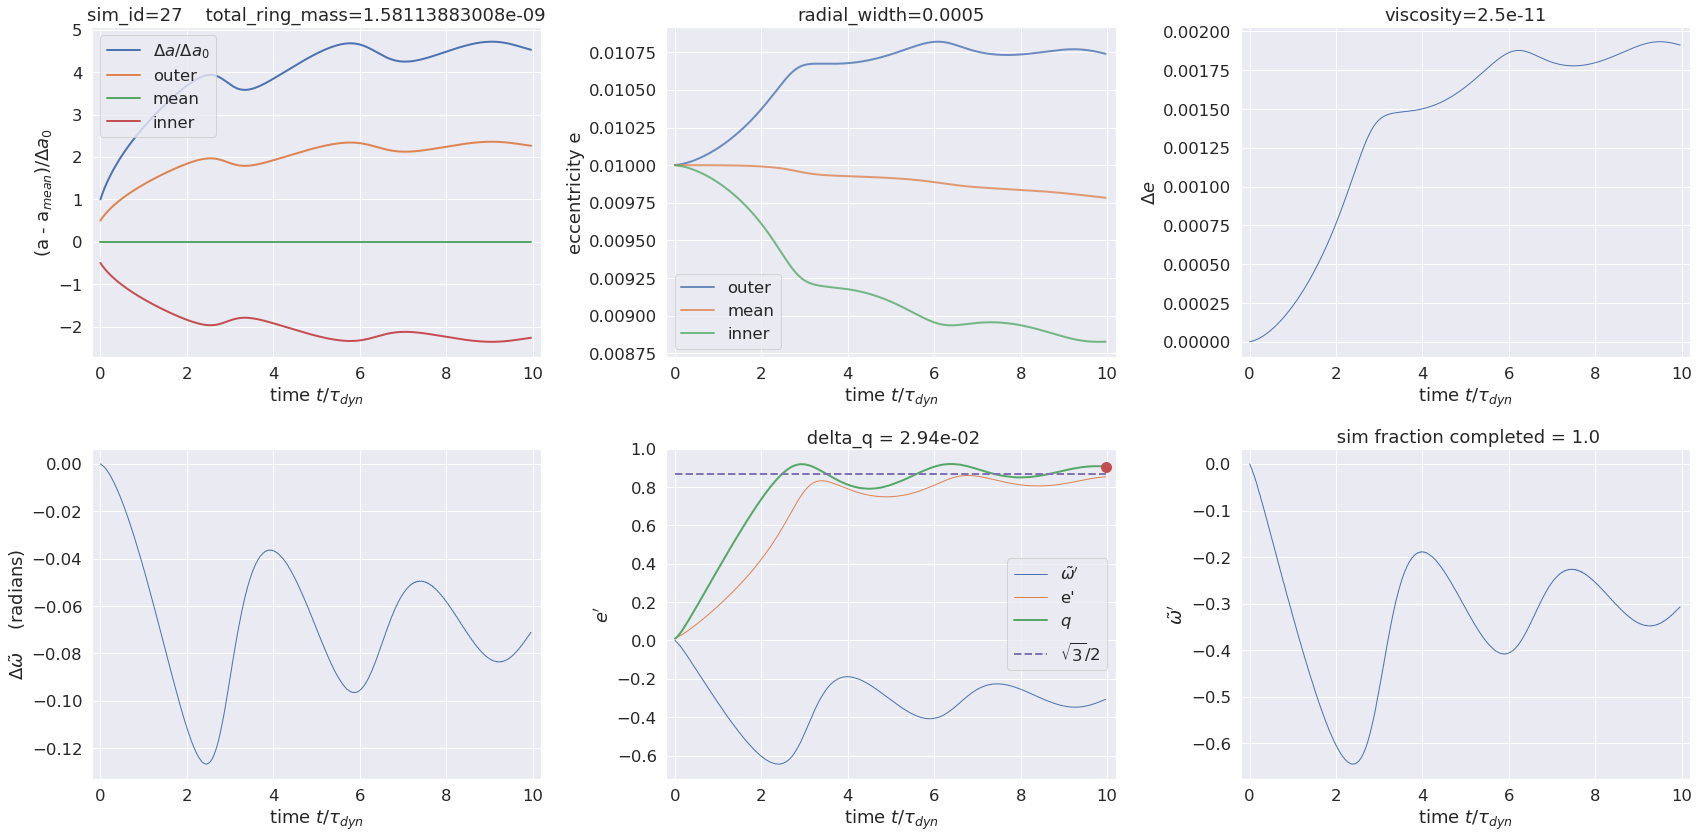

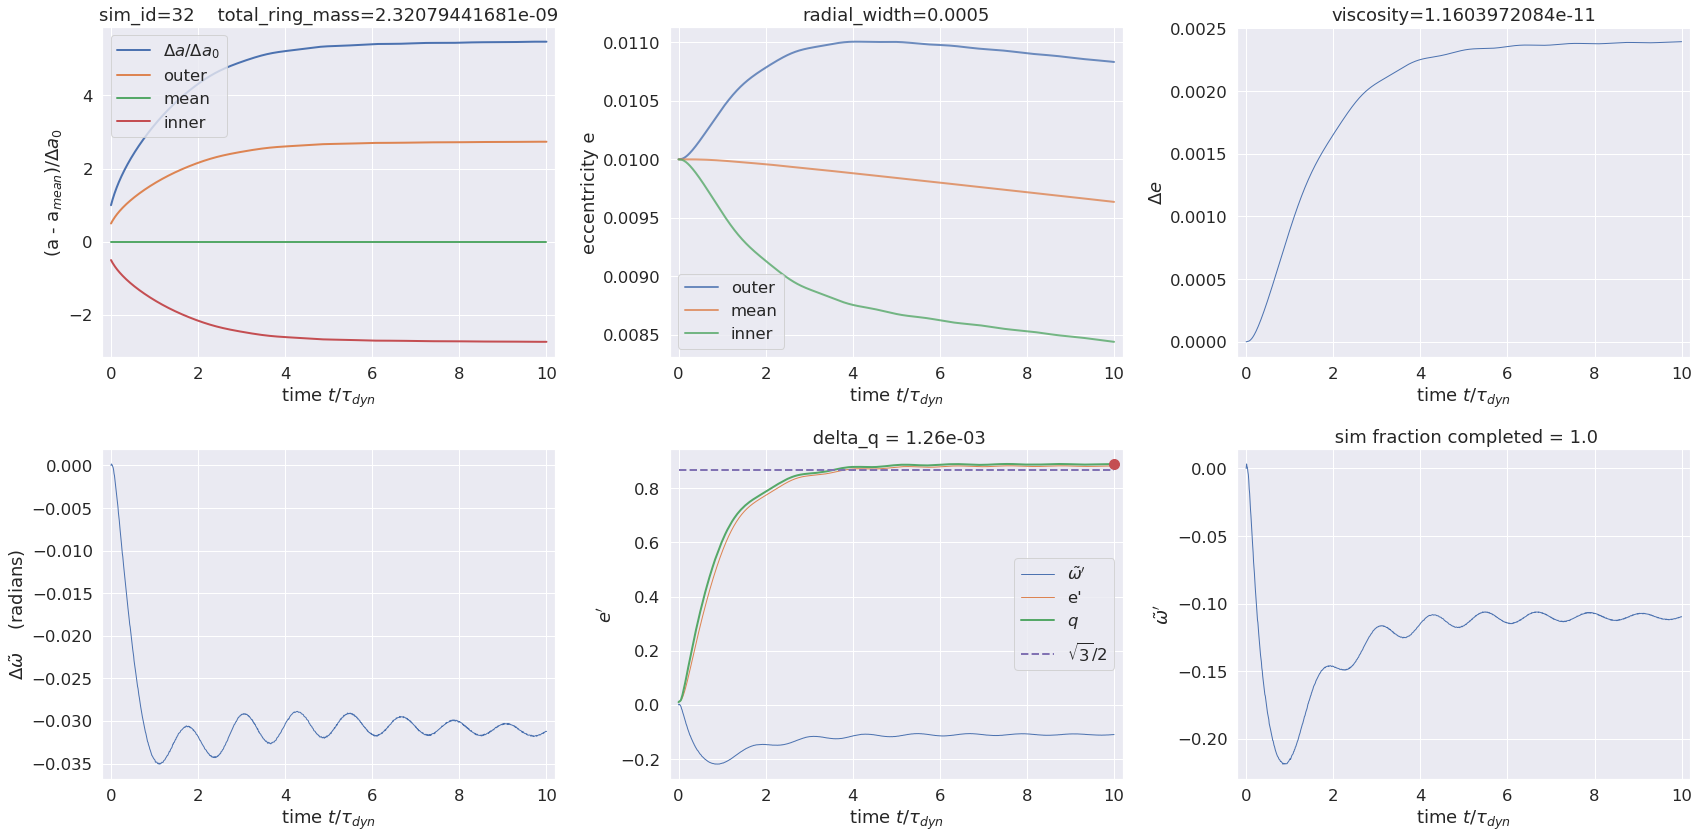

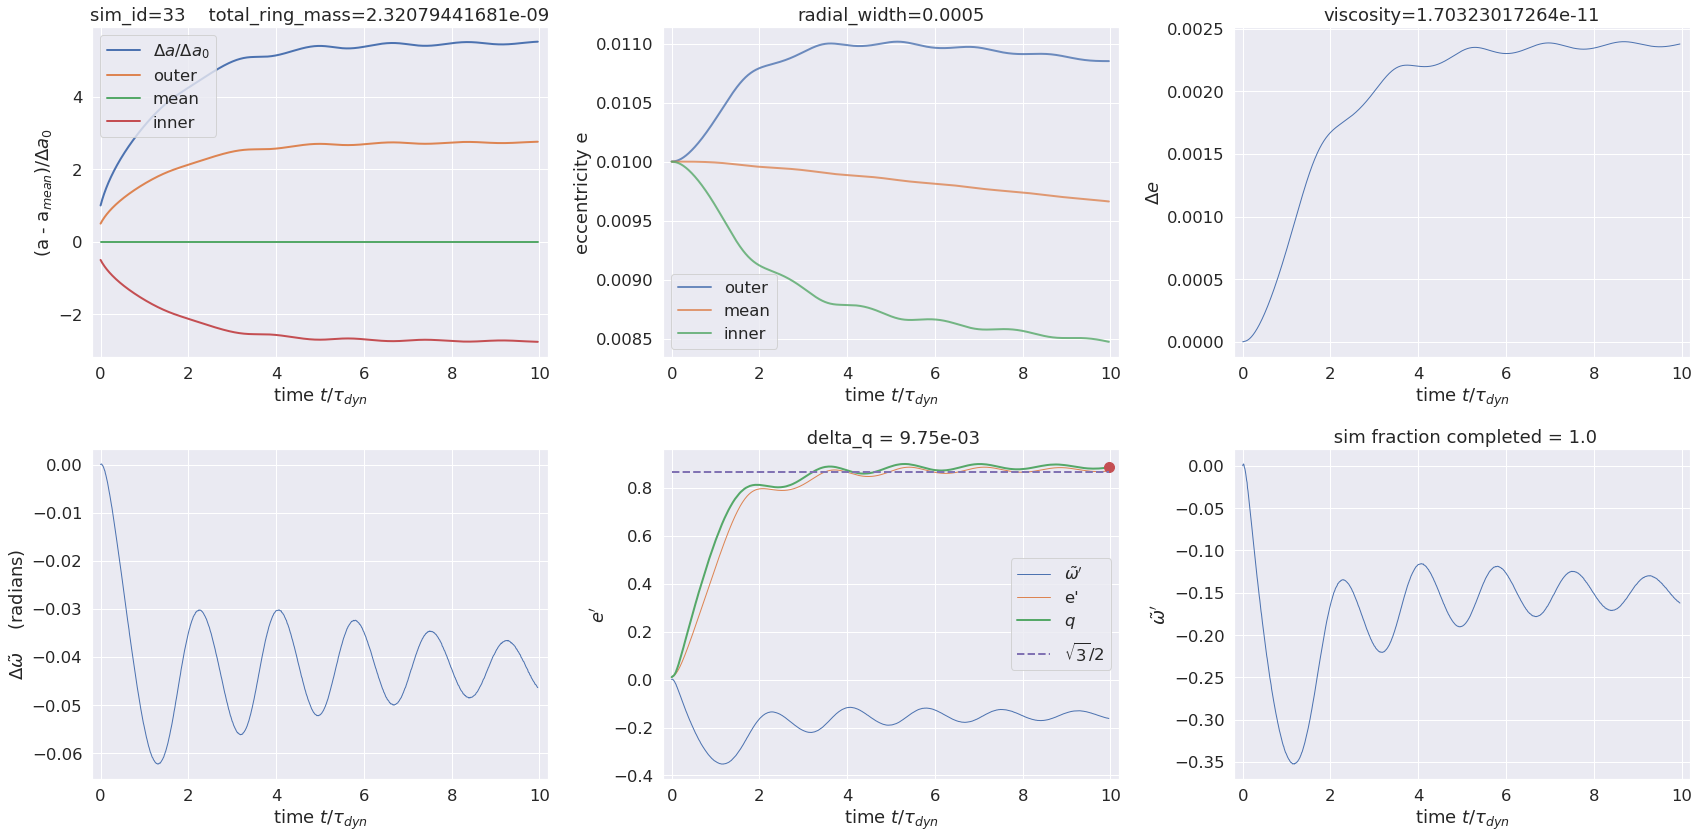

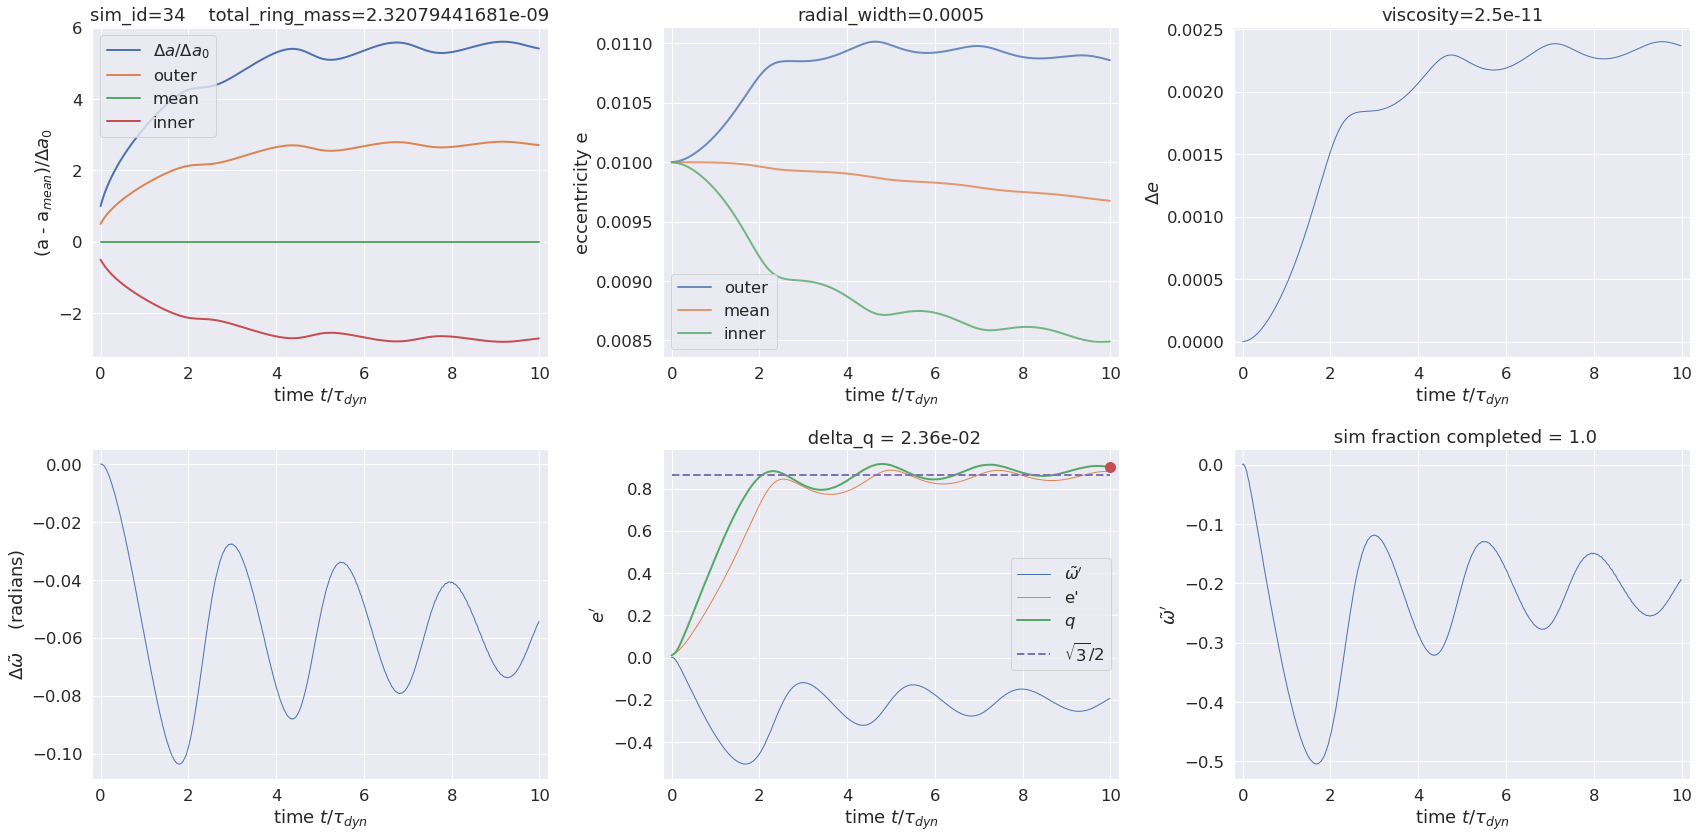

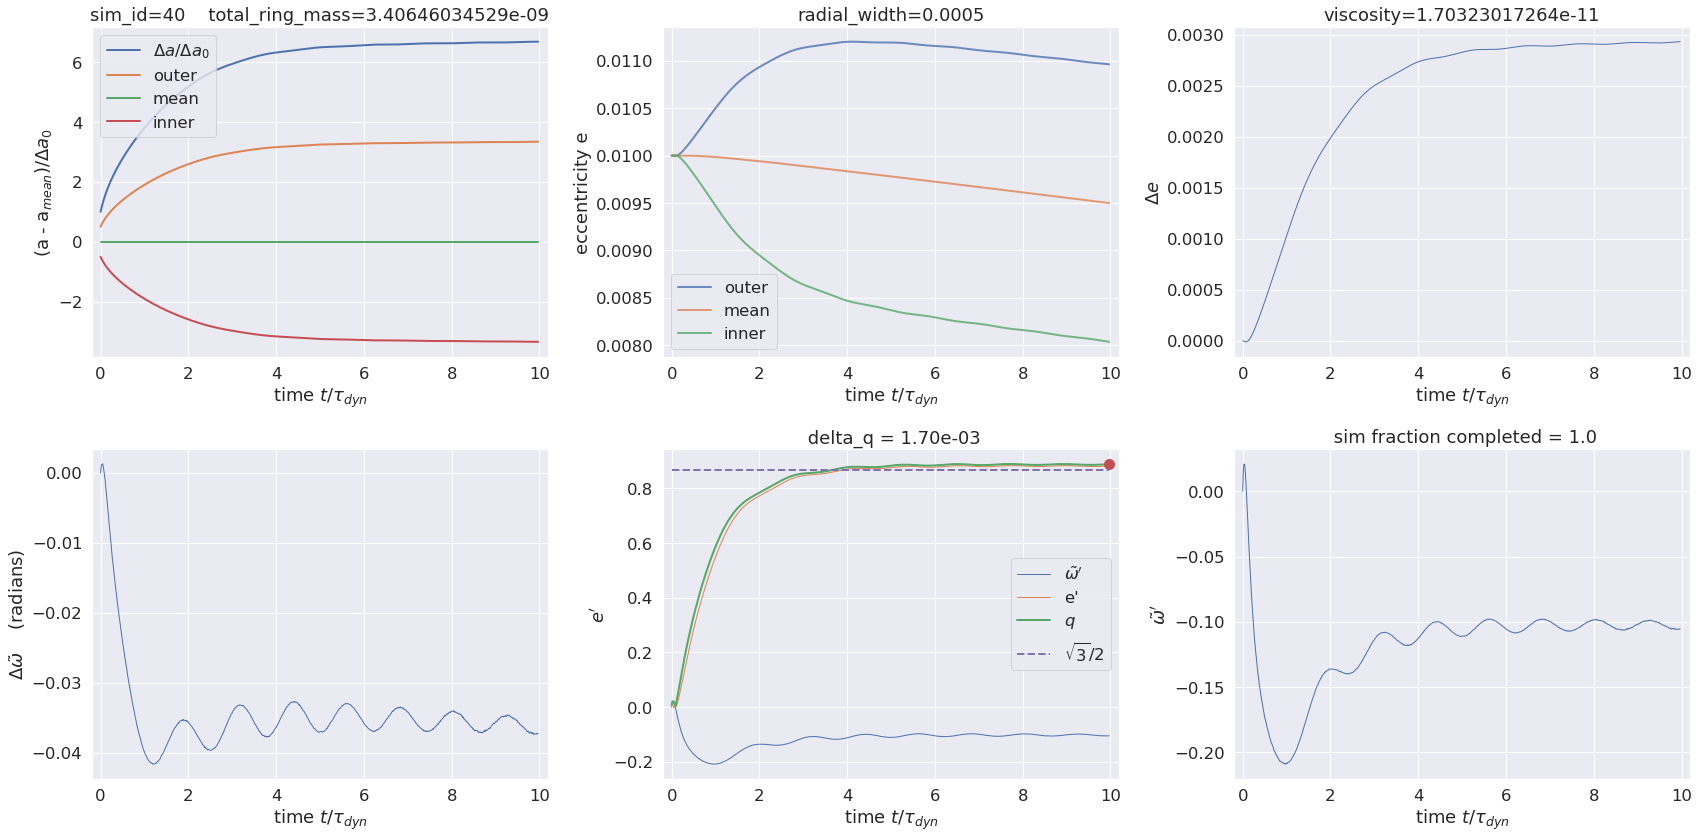

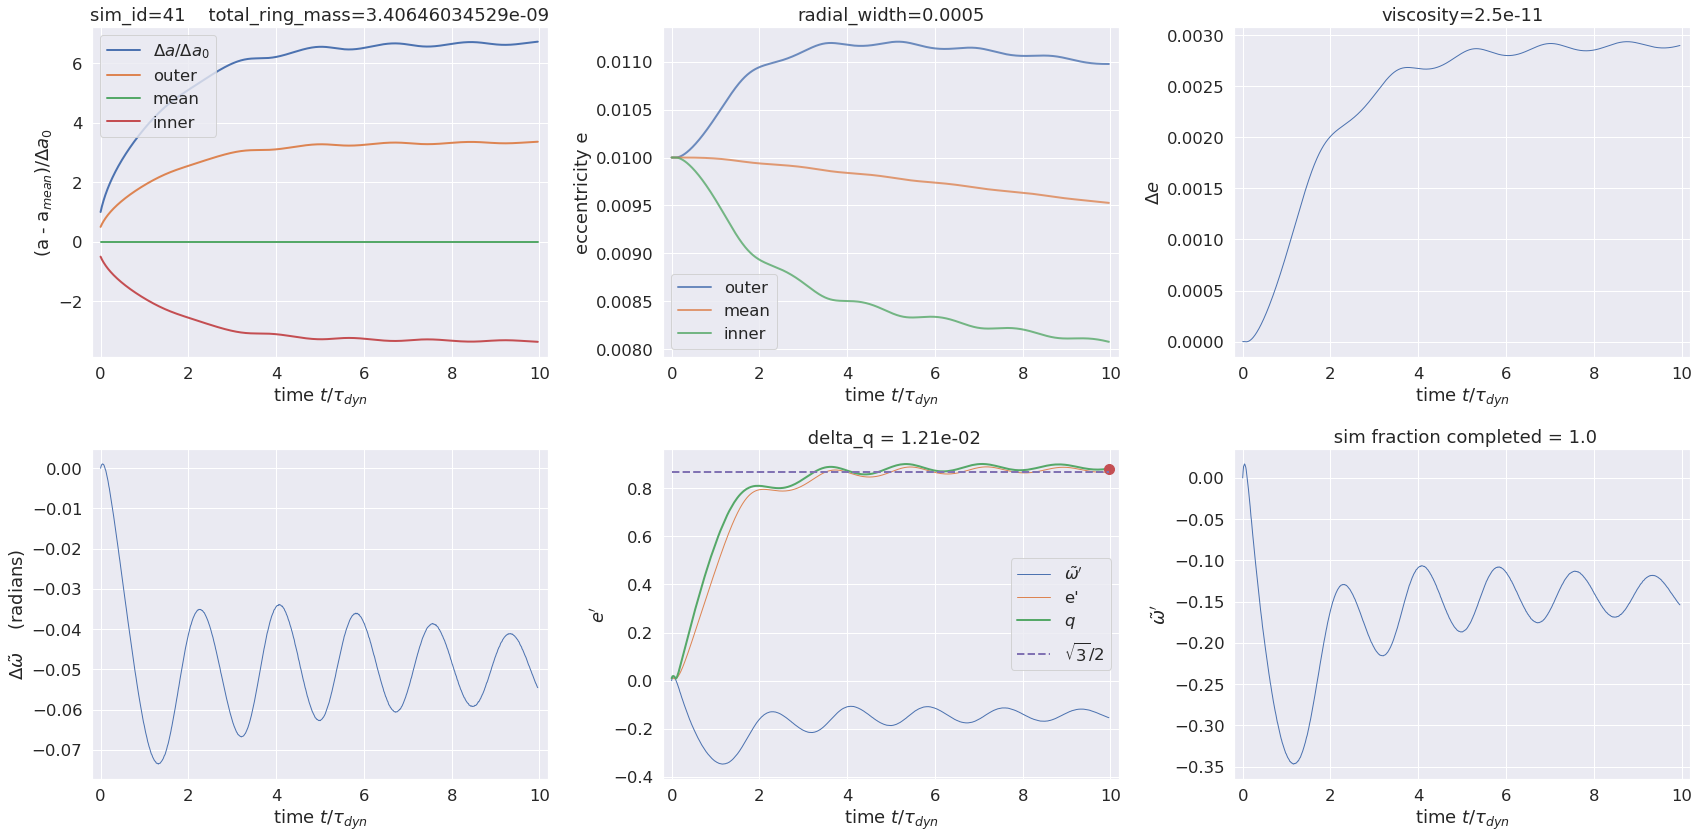

In [6]:
#generate grid of summary plots, for each sim that evolves to 100+ viscous timescales
debug = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['expected_timestep'] = expected_timestep

    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    d['times_dynamical_max'] = int(times_dynamical.max())
    
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    da_init = da[0]
    
    #compute e_prime, wt_prime, q to lowest order, and H(q)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    idx = (times_dynamical > 0.8*times_dynamical.max())
    d['q'] = q[idx].mean()
    d['delta_q'] = 0.5*(q[idx].max() - q[idx].min())
    d['wt_prime'] = wt_prime[idx].mean()
    
    #report on sims that execute without crossing streamlines
    if ((current_timestep == expected_timestep) and (np.abs(d['wt_prime']) < d['q']/2)):

        if (debug):
            print 'path = ', path
            print 'total_ring_mass = ', total_ring_mass
            print 'radial_width = ', radial_width
            print 'shear_viscosity = ', shear_viscosity
            print 'dynamical_timescale = ', dynamical_timescale
            print 'current, expected timesteps = ', current_timestep, expected_timestep
            print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0
        
        #create grid of plots
        sns.set(font_scale=1.5, font='DejaVu Sans')
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        
        #plot streamline's mutual a-evolution
        ax = axs[0][0]
        x = times_dynamical
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        title = 'sim_id=' + str(sim_id) + '    total_ring_mass=' + str(total_ring_mass)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()

        #plot streamline's e-evolution
        ax = axs[0][1]
        x = times_dynamical
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot delta_e versus time
        ax = axs[0][2]
        x = times_dynamical
        y = de
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta e$')
        title = 'viscosity=' + str(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot dwt versus time
        ax = axs[1][0]
        x = times_dynamical
        y = dwt
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot e_prime wt_prime and q versus time
        ax = axs[1][1]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        if (streamline_crossing_timestep == None):
            p = ax.plot(x[-1], y[-1], marker='o', markersize=10, label='')
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
        title = ' delta_q = ' + '{:.2e}'.format(d['delta_q'])
        p = ax.set_title(title)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot wt_prime versus time
        ax = axs[1][2]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        title = ' sim fraction completed = ' + str(current_timestep*1.0/expected_timestep)
        p = ax.set_title(title)

        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$\tilde{\omega}'$")
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
    
    data += [d]
df = pd.DataFrame(data)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep',
    'times_dynamical_max', 'total_ring_mass', 'radial_width', 'shear_viscosity', 'q', 'delta_q', 'wt_prime']
df = df[cols].sort_values('sim_id').reset_index(drop=True)
df_results = df

In [9]:
#list all sims that evolved into self-confining state
df = df_results
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
df[idx]
df_results

sim_id  expected_timestep  current_timestep  streamline_crossing_timestep  \
0        0             329000            329000                           NaN   
1        1             224000            224000                           NaN   
2        2             153000             22950                       22633.0   
3        3             104000             26000                       22029.0   
4        4              71000             24850                       22058.0   
5        5              48000             21600                       21040.0   
6        6              32000             22400                       22201.0   
7        7             484000            484000                           NaN   
8        8             329000            329000                           NaN   
9        9             224000            224000                           NaN   
10      10             153000            153000                           NaN   
11      11             104000             26000                       25330.0   
12      12              71000             24850                       22616.0   
13      13              48000             24000                       22507.0   
14      14             710000            710000                      674613.0   
15      15             484000            484000                           NaN   
16      16             329000            329000                           NaN   
17      17             224000            224000                           NaN   
18      18             153000            153000                           NaN   
19      19             104000             31200                       26736.0   
20      20              71000             28400                       25478.0   
21      21            1043000            521500                      506429.0   
22      22             710000            532500                      520465.0   
23      23             484000            484000                           NaN   
24      24             329000            329000                           NaN   
25      25             224000            224000                           NaN   
26      26             153000            153000                           NaN   
27      27             104000            104000                           NaN   
28      28            1531000            459300                      419117.0   
29      29            1043000            417200                      413139.0   
30      30             710000            426000                      416716.0   
31      31             484000            459800                      443398.0   
32      32             330000            330000                           NaN   
33      33             224000            224000                           NaN   
34      34             153000            153000                           NaN   
35      35            2248000            449600                      356374.0   
36      36            1531000            382750                      342131.0   
37      37            1043000            365050                      335902.0   
38      38             710000            355000                      332646.0   
39      39             484000            338800                      335563.0   
40      40             329000            329000                           NaN   
41      41             224000            224000                           NaN   
42      42            3300000            330000                      305203.0   
43      43            2248000            337200                      294576.0   
44      44            1531000            306200                      285341.0   
45      45            1043000            312900                      275523.0   
46      46             710000            284000                      268873.0   
47      47             484000            266200                      261694.0   
48      48             329000      

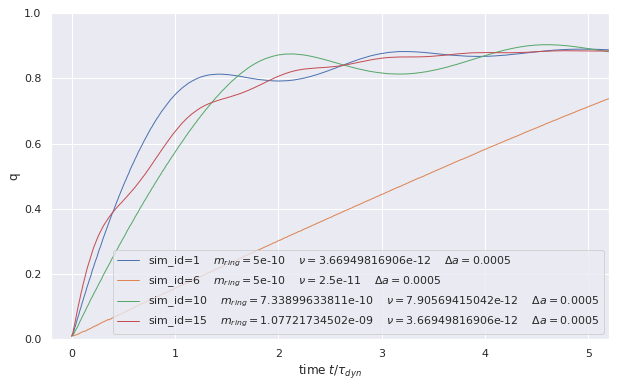

In [10]:
#plot q versus t/t_dynamical for selected sims having low libration amplitudes
df = paths_df
sim_ids = [1,  6, 10, 15]
xlim = (-0.2, 5.2)
ylim = (0.0, 1.0)
idx = df.sim_id.isin(sim_ids)
df = df[idx]
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
for idx, row in df.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #plot e_prime wt_prime and q versus time
    x = times_dynamical
    y = q
    label = 'sim_id=' + str(sim_id)
    label += r'    $m_{ring}=$' + str(total_ring_mass)
    label += r'    $\nu=$' + str(shear_viscosity)
    label += r'    $\Delta a =$' + str(radial_width)
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=label)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel('q')
    p = ax.set_xlim(xlim)
    p = ax.set_ylim(ylim)
    p = ax.legend()

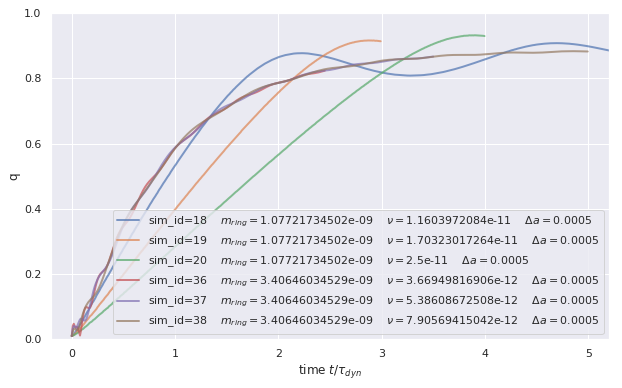

In [11]:
#confirm -0.25 power-law dempendance on radial_width by plotting q(t/t_dyn) for ringlet of constant mass & viscosity
#width_power_law = 0.33# No, green too high
#width_power_law = -0.0# green slightly too high?
#width_power_law = -0.1# maybe
width_power_law = -0.25# maybe
#width_power_law = -0.33# maybe
#width_power_law = -0.4# No, blue slightly too
#width_power_law = -0.5# No, blue slightly too high
#width_power_law = -1.0# No, blue too high
df = paths_df
sim_ids = [18, 19, 20, 36, 37, 38]
xlim = (-0.2, 5.2)
ylim = (0.0, 1.0)
idx = df.sim_id.isin(sim_ids)
df = df[idx]
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
#from helper_fns import *
#from libration import *
for idx, row in df.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #plot e_prime wt_prime and q versus time
    x = times_dynamical
    y = q
    label = 'sim_id=' + str(sim_id)
    label += r'    $m_{ring}=$' + str(total_ring_mass)
    label += r'    $\nu=$' + str(shear_viscosity)
    label += r'    $\Delta a =$' + str(radial_width)
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.7, label=label)
    p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
    p = ax.set_ylabel('q')
    p = ax.set_xlim(xlim)
    p = ax.set_ylim(ylim)
    p = ax.legend()

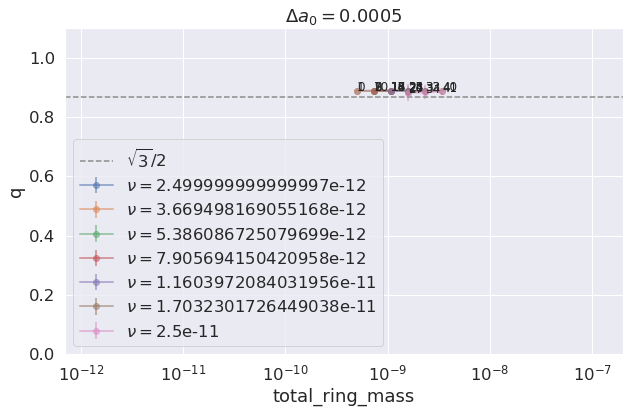

In [12]:
#plot q vs total_ring_mass, for each radial_width and shear_viscosity
df = df_results
shear_viscosities = df.shear_viscosity.sort_values().unique()
radial_widths = df.radial_width.sort_values().unique()
xlim = np.array([7.0e-13, 2.0e-7])
for radial_width in radial_widths:
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    xp = dfs.total_ring_mass
    yp = dfs.q
    for shear_viscosity in shear_viscosities:
        jdx = (dfs.shear_viscosity == shear_viscosity) & (dfs.wt_prime.abs() < dfs.q/2) \
            & (dfs.current_timestep == dfs.expected_timestep)
        dfss = dfs[jdx].sort_values('total_ring_mass')
        if (len(dfss) > 0):
            xp = dfss.total_ring_mass
            yp = dfss.q
            err = dfss.delta_q
            label = r'$\nu=$' + str(shear_viscosity)
            p = ax.errorbar(xp, yp, err, marker='o', alpha=0.5, markersize=6, linestyle='-', linewidth=2, label=label)
            id_str = dfss.sim_id.astype(str).values.tolist()
            xy = zip(xp, yp)
            for jdx, s in enumerate(id_str):
                p = ax.annotate(s, xy[jdx], fontsize=12)
    xp = xlim
    yp = xp*0 + np.sqrt(3)/2
    p = ax.plot(xp, yp, linestyle='dashed', label=r'$\sqrt{3}/2$')
    title = r'$\Delta a_0=$' + str(radial_width)
    p = ax.set_title(title)
    p = ax.set_xlabel('total_ring_mass')
    p = ax.set_ylabel('q')
    p = ax.set_xscale('log')
    p = ax.legend()
    p = ax.set_xlim(xlim)
    p = ax.set_ylim(0, 1.1)

In [13]:
print df.total_ring_mass.unique()
print df.radial_width.unique()
print df.shear_viscosity.unique()

[5.00000000e-10 7.33899634e-10 1.07721735e-09 1.58113883e-09
 2.32079442e-09 3.40646035e-09 5.00000000e-09]
[0.0005]
[2.50000000e-12 3.66949817e-12 5.38608673e-12 7.90569415e-12
 1.16039721e-11 1.70323017e-11 2.50000000e-11]
